## EEG Source Localization and ICA Analysis

In [166]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import mne
import nibabel as nib
import nilearn.plotting as nplt
from nilearn import datasets, image, plotting
import os

mne.set_log_level('WARNING') 

# Load EEG Data
- Here, we specify the subject and analysis type (psych or control), define file paths, and load EEG recordings.


In [167]:
subject = 1  # Change this to the subject number you want to analyze (1-11)
analysis_type = "psych"  # Choose "psych" or "control"


base_dir = "C:\\Users\\User\\Desktop\\BCI Psych\\Data"
subject_folder = os.path.join(base_dir, f"Subject {subject}")
baseline_file = os.path.join(subject_folder, f"Subject{subject}_{analysis_type}_bl.edf")
condition_file = os.path.join(subject_folder, f"Subject{subject}_{analysis_type}_condition.edf")

In [168]:
baseline = mne.io.read_raw_edf(baseline_file, preload=True)

condition = mne.io.read_raw_edf(condition_file, preload=True)

print(f"Loaded files:\nBaseline: {baseline_file}\nCondition: {condition_file}")

Loaded files:
Baseline: C:\Users\User\Desktop\BCI Psych\Data\Subject 1\Subject1_psych_bl.edf
Condition: C:\Users\User\Desktop\BCI Psych\Data\Subject 1\Subject1_psych_condition.edf


## Preprocess EEG Data
- Set electrode montages to the standard 10-20 system.
- Apply average referencing.
- Preload EEG data for analysis.


In [169]:
montage = mne.channels.make_standard_montage('standard_1020')
baseline.set_montage(montage)
baseline.set_eeg_reference('average', projection=True, verbose =None)  # add average-ref projector
baseline.apply_proj()  # actually apply the projector to the data


condition.set_montage(montage)
condition.set_eeg_reference('average', projection=True, verbose =None)  # add average-ref projector
condition.apply_proj()  # actually apply the projector to the data

<RawEDF | Subject1_psych_condition.edf, 65 x 103424 (404.0 s), ~51.4 MiB, data loaded>

# Setup Forward Model for Source Localization
- Load `fsaverage` template for source modeling.
- Define a volumetric source space.


In [170]:
from mne.datasets import fetch_fsaverage

############################################################################
# 1) Fetch fsaverage and set up a volume source space
############################################################################
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = fs_dir.parent
subject = 'fsaverage'
# For example, make a 5 mm volumetric grid in the brain:
volume_src = mne.setup_volume_source_space(
    subject=subject,
    pos=5.0,  # mm spacing, can adjust to e.g. 7.0 if you like
    bem=fs_dir / "bem" / "fsaverage-5120-5120-5120-bem-sol.fif",
    subjects_dir=subjects_dir,
    mindist=5.0,  # exclude points too close to inner skull
    add_interpolator=True,
    verbose=True
)

############################################################################
# 2) Make the forward solution with the volume source space
############################################################################
fwd = mne.make_forward_solution(
    info=baseline.info,      # or evoked.info, etc.
    trans='fsaverage',  # built-in fsaverage transform
    src=volume_src,
    bem=fs_dir / "bem" / "fsaverage-5120-5120-5120-bem-sol.fif",
    eeg=True, 
    mindist=5.0
)
############################################################################
# 3) Compute noise covariance and create the inverse operator
############################################################################
noise_cov = mne.compute_raw_covariance(baseline, method='shrunk', rank=None, picks='eeg')
inverse_operator = mne.minimum_norm.make_inverse_operator(
    info=baseline.info,
    forward=fwd,
    noise_cov=noise_cov,
    loose='auto',  # typically 0.0 or None for volumetric
    depth=0.8
)

0 files missing from root.txt in C:\Users\User\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\User\mne_data\MNE-fsaverage-data\fsaverage
BEM              : C:\Users\User\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : C:\Users\User\mne_data\MNE-fsaverage-data\fsaverage\mri\T1.mgz

Reading C:\Users\User\mne_data\MNE-fsaverage-data\fsaverage\mri\T1.mgz...

Loaded inner skull from C:\Users\User\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif (2562 nodes)
Surface CM = (  -0.5  -21.1    6.2) mm
Surface fits inside a sphere with radius   98.3 mm
Surface extent:
    x =  -75.2 ...   76.3 mm
    y = -113.3 ...   75.0 mm
    z =  -71.7 ...   88.2 mm
Grid extent:
    x =  -80.0 ...   80.0 mm
    y = -115.0 ...   75.0 mm
    z =  -75.0 ...   90.0 mm
43758 sources before omitting any.
29824 sources after omitting infeasible source

In [171]:
mne.viz.plot_alignment(
    baseline.info,
    src=volume_src,
    eeg=["original", "projected"],
    trans='fsaverage',
    show_axes=True,
    mri_fiducials=True,
    dig="fiducials",
)


False


# Perform ICA on EEG Data
- Apply Independent Component Analysis (ICA) on baseline data


C:\Users\User\AppData\Local\Temp\ipykernel_2592\3176007477.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(baseline)


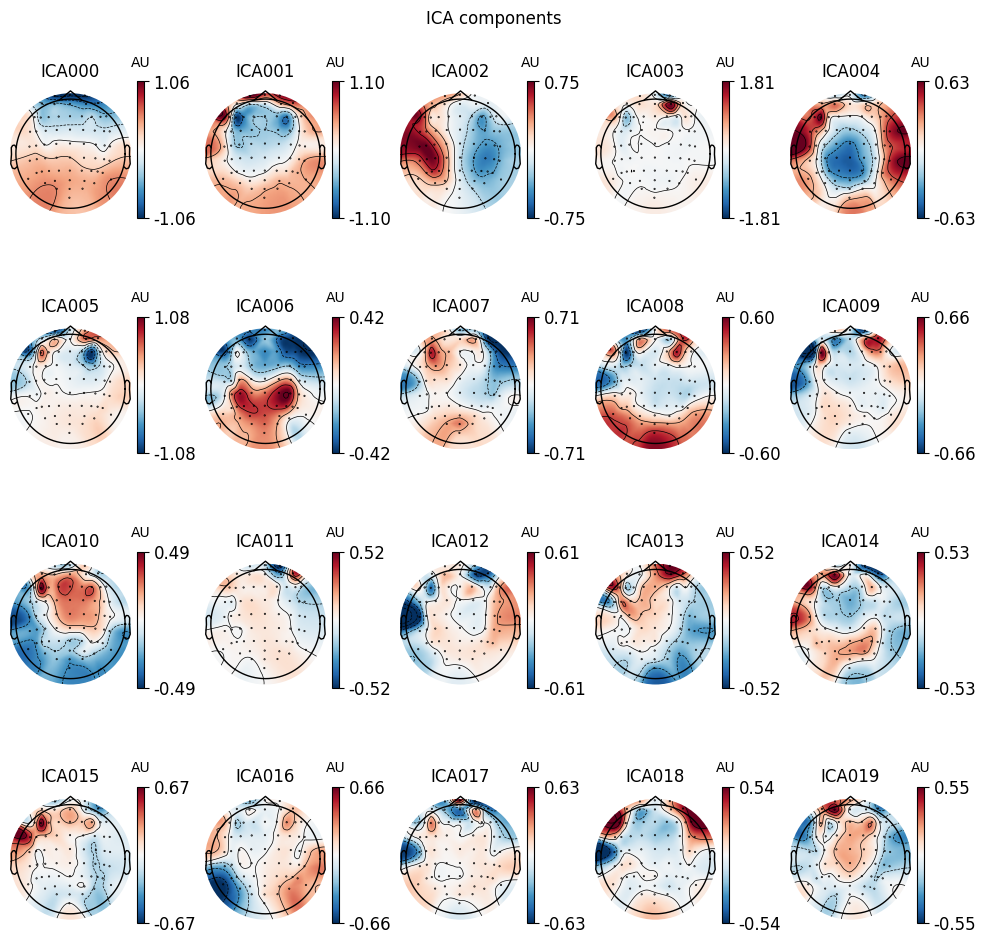

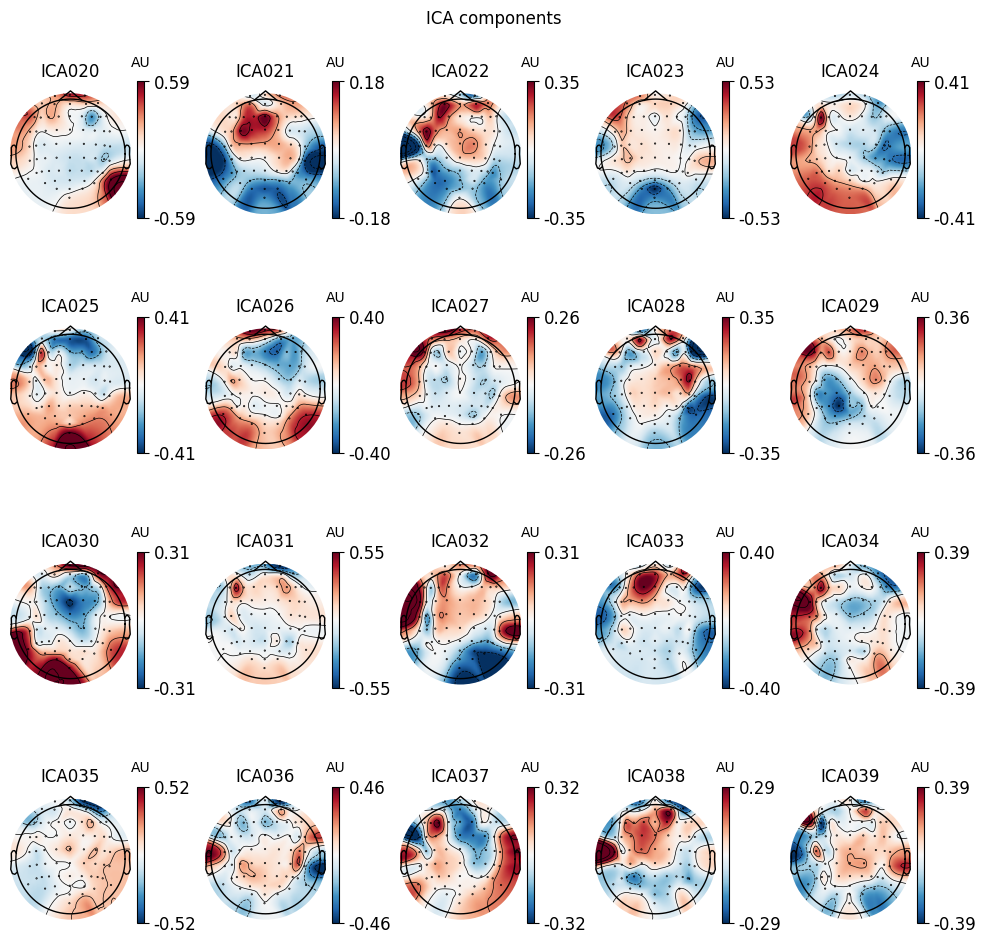

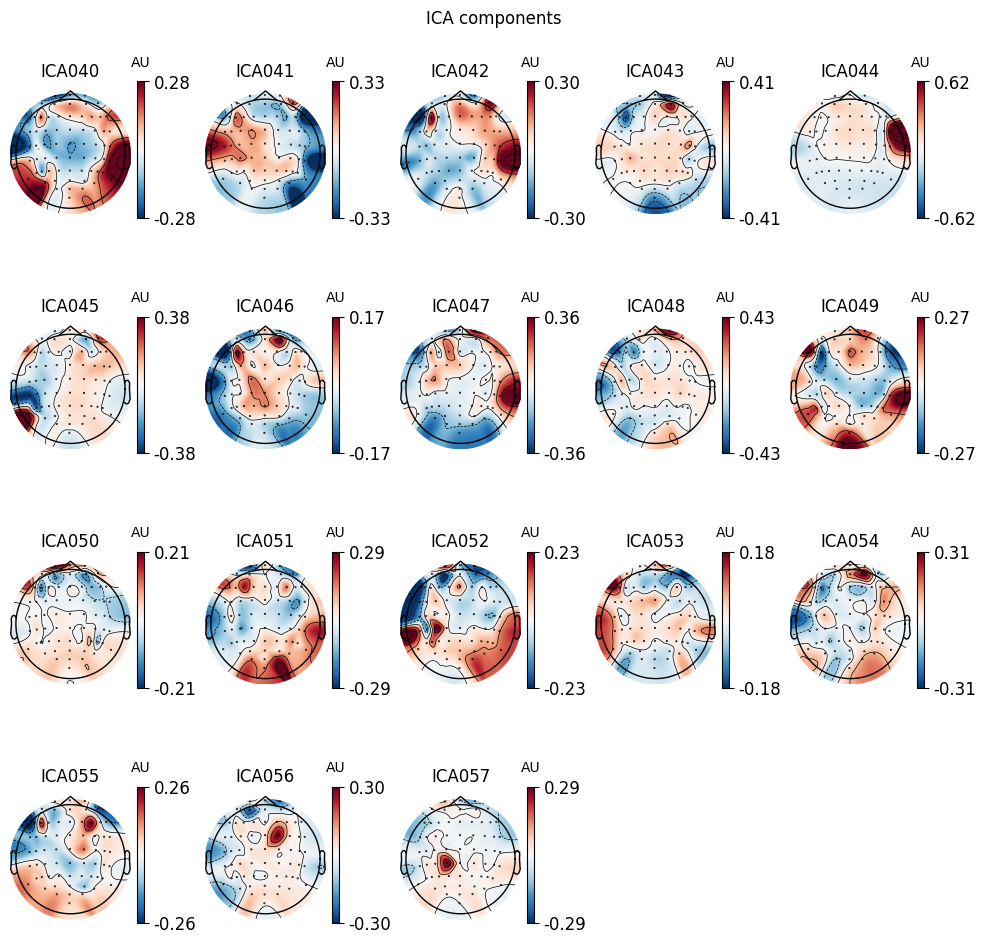

In [172]:
ica = mne.preprocessing.ICA(n_components=0.999999, method='infomax', fit_params=dict(extended=True), random_state=40)
ica.fit(baseline)

ica.plot_components(inst=baseline, colorbar=True)

plt.show()


#  Identify and Retain Brain Components
- Use ICLabel to classify ICA components.
- Retain only brain-related components with ≥70% probability.


C:\Users\User\AppData\Local\Temp\ipykernel_2592\2227784409.py:4: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  labels = label_components(baseline, ica, method="iclabel")
C:\Users\User\AppData\Local\Temp\ipykernel_2592\2227784409.py:4: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(baseline, ica, method="iclabel")


Keeping only brain components with ≥ 50% probability.


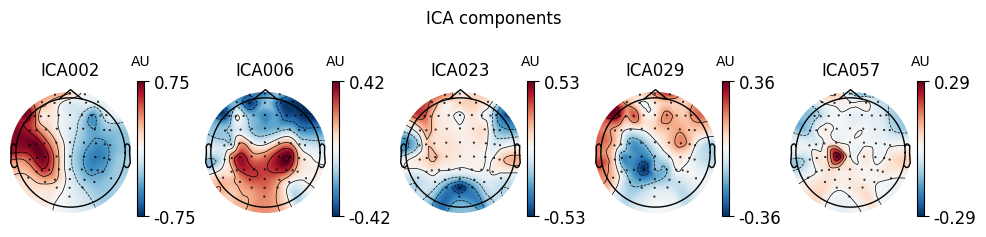

98.866035
99.31924
76.60578
94.381935
86.04092


In [ ]:
from mne_icalabel import label_components
import matplotlib.pyplot as plt

labels = label_components(baseline, ica, method="iclabel")


ica.exclude = []

for comp_idx, label in enumerate(labels["labels"]):
    prob_vector = labels["y_pred_proba"][comp_idx]

    brain_prob = prob_vector  # 'brain' is always the first class

    if label != "brain" or brain_prob < 0.7:
        ica.exclude.append(comp_idx)

print("Keeping only brain components with ≥ 70% probability.")




kept_components = [i for i in range(len(labels["labels"])) if i not in ica.exclude]

fig = ica.plot_components(picks=kept_components, inst=baseline, colorbar=True)

for i, ax in enumerate(fig.axes):
    if i < len(kept_components):  
        comp_idx = kept_components[i]
        label = labels["labels"][comp_idx]
        prob = labels["y_pred_proba"][comp_idx] * 100  
        print(prob)
        ax.set_title(f"{label} ({prob:.1f}%)", fontsize=10)

plt.show()

### These are the selected ICs we believe to be representative of brain activity. ^

In [188]:
ics_of_interest = kept_components

# Source Localization of ICA Components
- For each of our selected ICs we are going to try and source localize the component using eLORETA
- After localization, in order to find a measure of conformity to the PCC node of the Default Mode Network we will calculate the dice similarity coefficient and average distance from a PCC template(plotted in blue).


[get_dataset_dir] Dataset found in C:\Users\User\nilearn_data\fsl


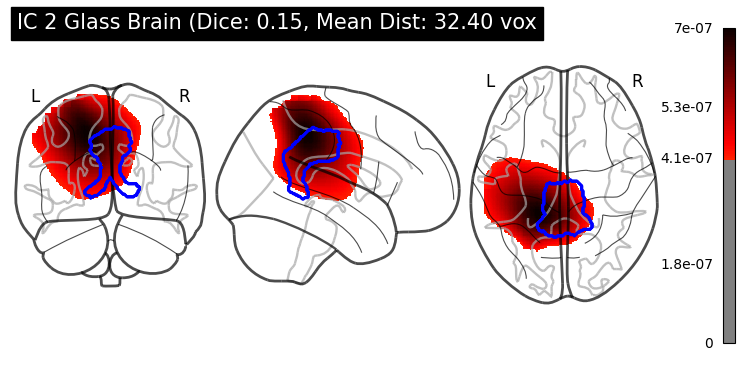

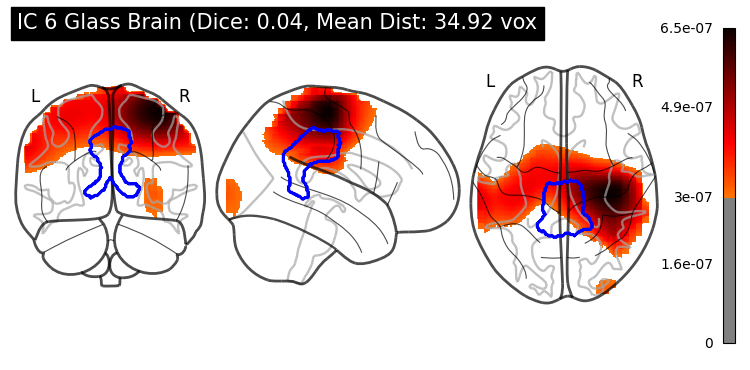

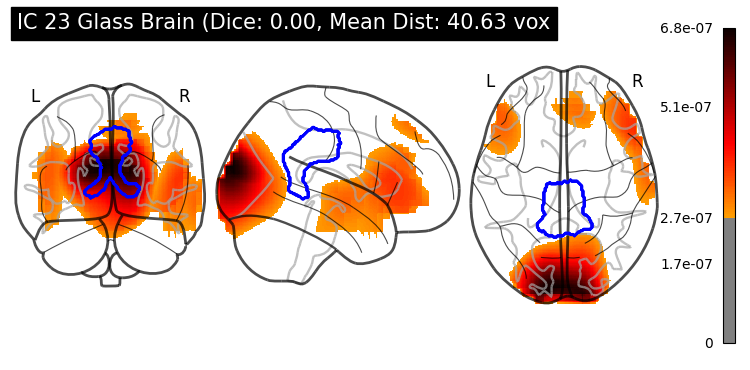

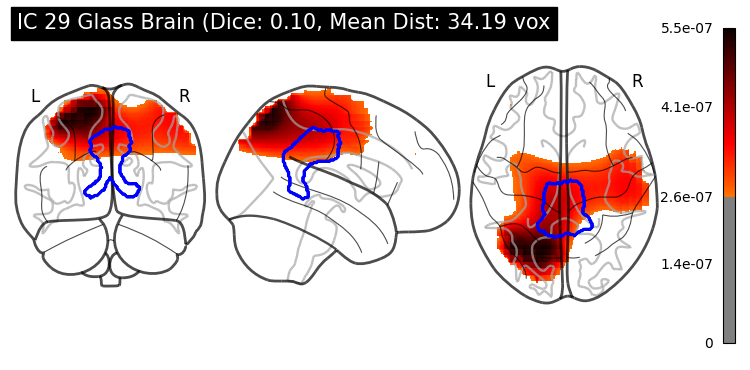

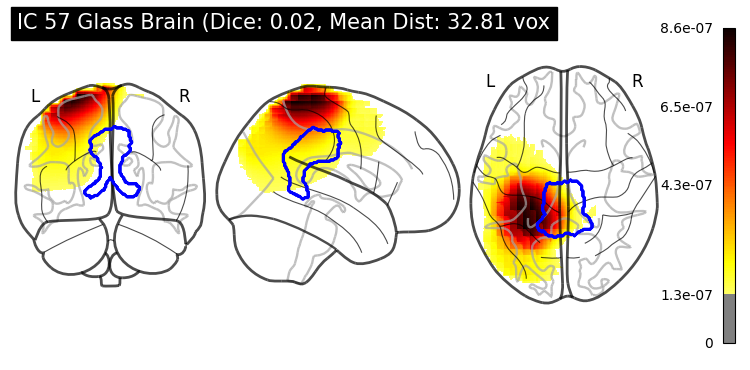

In [189]:
import numpy as np
import nibabel as nib
from nilearn import datasets, image, plotting
from scipy.ndimage import binary_fill_holes, distance_transform_edt

# Fetch Harvard-Oxford atlas
atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-1mm")
atlas_img = atlas.maps
atlas_labels = atlas.labels

# Find the PCC region index
pcc_index = atlas_labels.index("Cingulate Gyrus, posterior division")

# Extract PCC mask and convert it to a binary mask
pcc_mask = image.math_img(f"img == {pcc_index}", img=atlas_img)
pcc_data = np.squeeze(pcc_mask.get_fdata()) > 0

# Fill the PCC mask to ensure a solid region
pcc_filled = binary_fill_holes(pcc_data)
distance_map = distance_transform_edt(1 - pcc_filled)

overlap_results = []

for ic_index in ics_of_interest:
    component_maps = ica.get_components()
    scalp_map = component_maps[:, ic_index]  

    evoked_data = scalp_map[:, np.newaxis]  
    evoked = mne.EvokedArray(evoked_data, ica.info, tmin=0)
    evoked.comment = f'IC {ic_index} scalp map'

    stc_vol = mne.minimum_norm.apply_inverse(
        evoked, inverse_operator, lambda2=1.0/9.0, method='eLORETA'
    )

    stc_vol.save_as_volume(
        'my_volume_stc2.nii.gz',
        src=volume_src,
        dest='mri',
        mri_resolution=True,
        overwrite=True
    )

    img = nib.load('my_volume_stc2.nii.gz')

    # Resample the IC activation image to match the PCC mask resolution.
    img_resampled = image.resample_to_img(
        img, pcc_mask, interpolation="linear", force_resample=True, copy_header=True
    )

    # Get continuous IC activation data, clip negatives, and normalize to [0,1]
    ic_data_cont = np.squeeze(img_resampled.get_fdata())
    ic_data_cont = np.clip(ic_data_cont, 0, None)
    if np.max(ic_data_cont) > 0:
        ic_data_norm = ic_data_cont / np.max(ic_data_cont)
    else:
        ic_data_norm = ic_data_cont

    threshold_value = np.percentile(ic_data_cont[ic_data_cont != 0], 90)
    ic_data_bin = (ic_data_cont > threshold_value).astype(int)
    intersection = np.logical_and(ic_data_bin, pcc_filled).sum()
    if (ic_data_bin.sum() + pcc_filled.sum()) > 0:
        dice = (2. * intersection) / (ic_data_bin.sum() + pcc_filled.sum())
    else:
        dice = 0

    # Compute the weighted mean distance from the IC activation to the PCC
    # Weight the distance transform by the normalized activation.
    if np.sum(ic_data_norm) > 0:
        mean_distance = np.sum(ic_data_norm * distance_map) / np.sum(ic_data_norm)
    else:
        mean_distance = np.inf

    overlap_results.append((ic_index, dice, mean_distance))

    display = plotting.plot_glass_brain(
        img_resampled,
        threshold=threshold_value,
        title=(f"IC {ic_index} Glass Brain (Dice: {dice:.2f}, "
               f"Mean Dist: {mean_distance:.2f} vox"),
        colorbar=True
    )
    # Overlay the filled PCC mask as blue contours.
    pcc_mask_filled = nib.Nifti1Image(pcc_filled.astype(np.uint8), affine=pcc_mask.affine)
    display.add_contours(pcc_mask_filled, colors='blue')
    plotting.show()


#### We can now combine the two metrics into a similarity score between 0-1 to choose the most PCC localizing IC

In [190]:
import numpy as np
from scipy.stats import rankdata


dice_array = np.array([entry[1] for entry in overlap_results])
mean_distance_array = np.array([entry[2] for entry in overlap_results])

dice_ranks = rankdata(dice_array, method='average')
norm_dice = (dice_ranks - np.min(dice_ranks)) / (np.max(dice_ranks) - np.min(dice_ranks))


distance_ranks = rankdata(-mean_distance_array, method='average')
norm_distance = (distance_ranks - np.min(distance_ranks)) / (np.max(distance_ranks) - np.min(distance_ranks))

combined_similarity = (norm_dice + norm_distance) / 2

combined_results = [
    (entry[0], entry[1], entry[2], combined_similarity[i])
    for i, entry in enumerate(overlap_results)
]

# Print summary results.
print("\n==== Combined Similarity Results ====")
for ic_idx, dice, mean_distance, combined in combined_results:
    print(f"IC {ic_idx}: Dice = {dice:.3f}, Mean Distance = {mean_distance:.2f} vox, Combined Similarity = {combined:.3f}")




==== Combined Similarity Results ====
IC 2: Dice = 0.151, Mean Distance = 32.40 vox, Combined Similarity = 1.000
IC 6: Dice = 0.038, Mean Distance = 34.92 vox, Combined Similarity = 0.375
IC 23: Dice = 0.000, Mean Distance = 40.63 vox, Combined Similarity = 0.000
IC 29: Dice = 0.105, Mean Distance = 34.19 vox, Combined Similarity = 0.625
IC 57: Dice = 0.015, Mean Distance = 32.81 vox, Combined Similarity = 0.500


## Compare the properties of the selected IC

These are the basic properties of the selected IC when it is projected from the `baseline` data(the resting state recording we derive the ICs from)

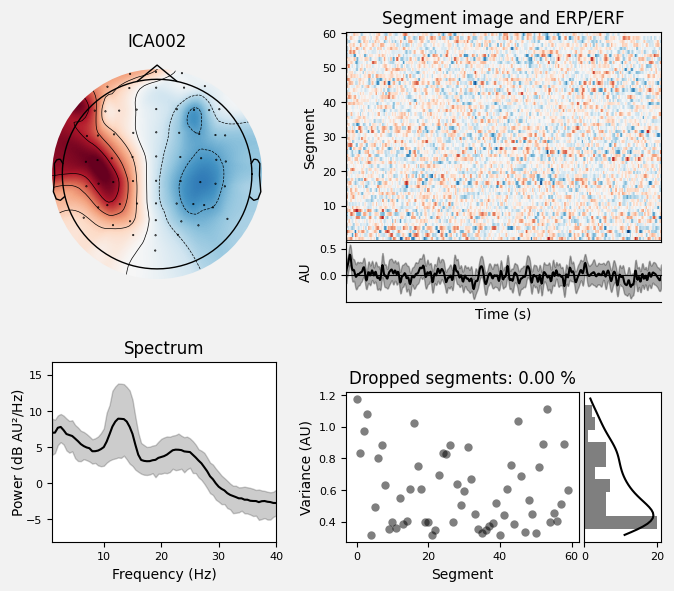

[<Figure size 700x600 with 6 Axes>]

In [191]:
ic_of_interest, best_dice, best_distance, best_similarity = max(combined_results, key=lambda x: x[3])


ica.plot_properties(
    baseline, 
    picks=[ic_of_interest],
    psd_args={'fmin': 1, 'fmax': 40} 
)


These are the basic properties of the selected IC when it is projected from the `condition` data(the EEG recordings from when the subject is in the VR stimulus condition)

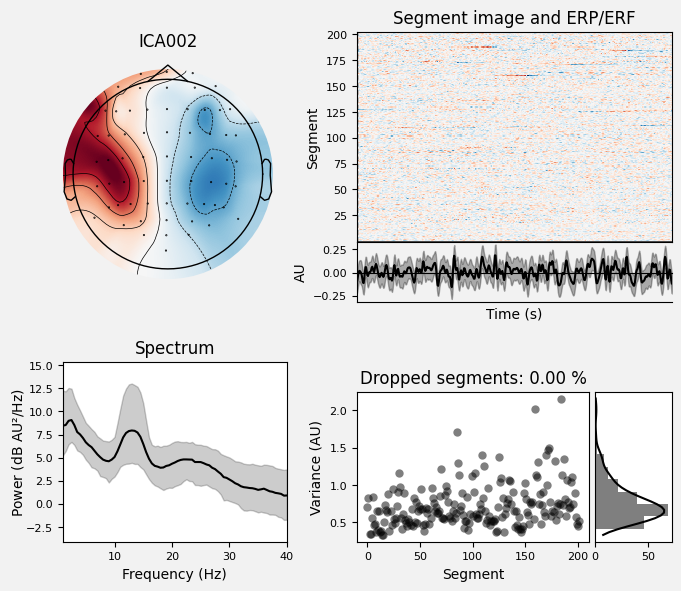

[<Figure size 700x600 with 6 Axes>]

In [192]:
ica.plot_properties(
    condition, 
    picks=[ic_of_interest],
    psd_args={'fmin': 1, 'fmax': 40} 
)

#  Compare Power Spectra of Selected ICA Component
- Compute and plot power spectral densities (PSD) for the chosen ICA component.
- Compare baseline vs. condition states.


In [193]:
baseline_data_ica = ica.get_sources(baseline).pick([ic_of_interest]) 
condition_data_ica = ica.get_sources(condition).pick([ic_of_interest]) 

PSD is calculated using Welch's method

In [194]:
baseline_spectrum = baseline_data_ica.compute_psd(fmin=1, fmax=50, picks = 'misc')
condition_spectrum = condition_data_ica.compute_psd(fmin=1, fmax=50,picks = 'misc')

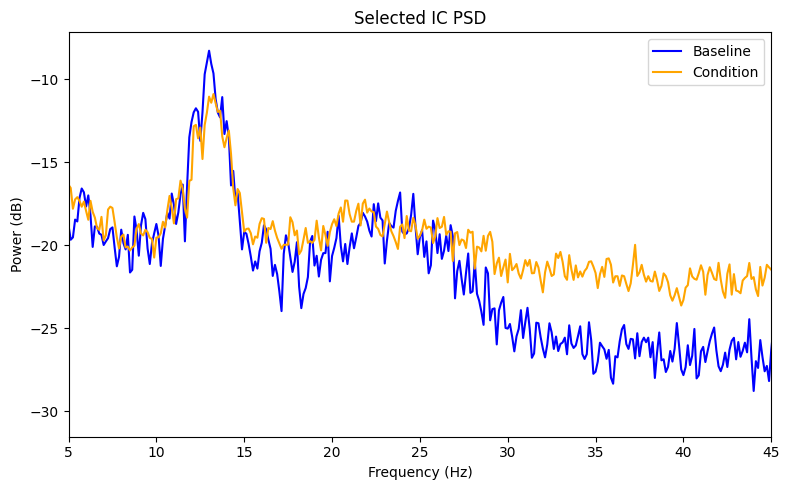

In [195]:
freqs_b = baseline_spectrum.freqs
psd_b_linear = baseline_spectrum.get_data(picks='misc')[0]  # shape: (n_freqs,)

freqs_c = condition_spectrum.freqs
psd_c_linear = condition_spectrum.get_data(picks='misc')[0]

psd_b_db = 10 * np.log10(psd_b_linear)
psd_c_db = 10 * np.log10(psd_c_linear)

plt.figure(figsize=(8, 5))

plt.plot(freqs_b, psd_b_db, label='Baseline', color='blue')
plt.plot(freqs_c, psd_c_db, label='Condition', color='orange')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('Selected IC PSD')
plt.xlim([5, 45])
#plt.ylim([-30, 5])
plt.legend()
plt.tight_layout()
plt.show()


#  Compare Power Spectra of 10 Selected Channels
- Compute and plot power spectral densities (PSD) for the 10 selected channels used for the previous BCI approach.
- Compare baseline vs. condition states.


PSD is calculated using Welch's method

In [196]:
chosen = ["P3", "P1", "P2", "P4", "PO3", "POz", "PO4", "O1", "Oz", "O2"]
baseline_spectrum_noICA = baseline.compute_psd(fmin=1, fmax=50, picks = chosen)
condition_spectrum_noICA = condition.compute_psd(fmin=1, fmax=50, picks = chosen)

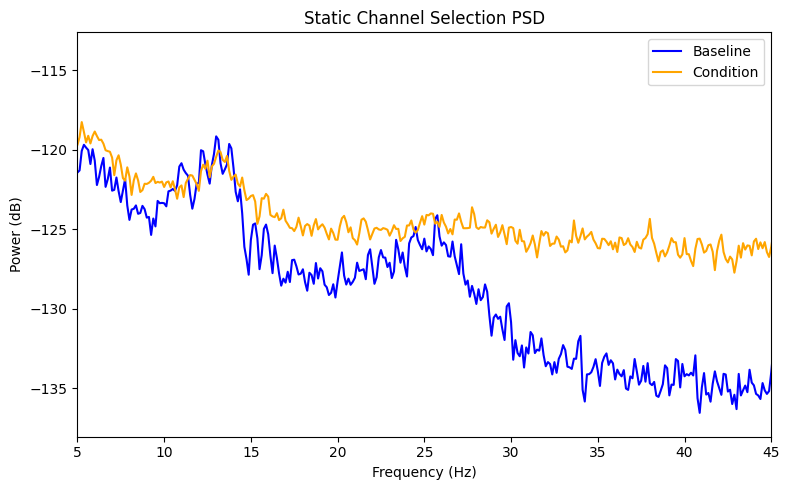

In [197]:
freqs_b = baseline_spectrum_noICA.freqs           
psd_b_linear_all = baseline_spectrum_noICA.get_data(picks='all')  

psd_b_linear_mean = np.mean(psd_b_linear_all, axis=0)  # shape: (n_freqs,)

freqs_c = condition_spectrum_noICA.freqs
psd_c_linear_all = condition_spectrum_noICA.get_data(picks='all')  
psd_c_linear_mean = np.mean(psd_c_linear_all, axis=0)

psd_b_db = 10 * np.log10(psd_b_linear_mean)
psd_c_db = 10 * np.log10(psd_c_linear_mean)



plt.figure(figsize=(8, 5))

plt.plot(freqs_b, psd_b_db, label='Baseline', color='blue')
plt.plot(freqs_c, psd_c_db, label='Condition', color='orange')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('Static Channel Selection PSD')
plt.xlim([5, 45])
#plt.ylim([-140, -105])
plt.legend()
plt.tight_layout()
plt.show()


# Compute and Compare Relative Band Power
- Compute relative power in key frequency bands (Delta, Theta, Alpha, Beta, Gamma).
- Compare ICA and static channel selection approaches.


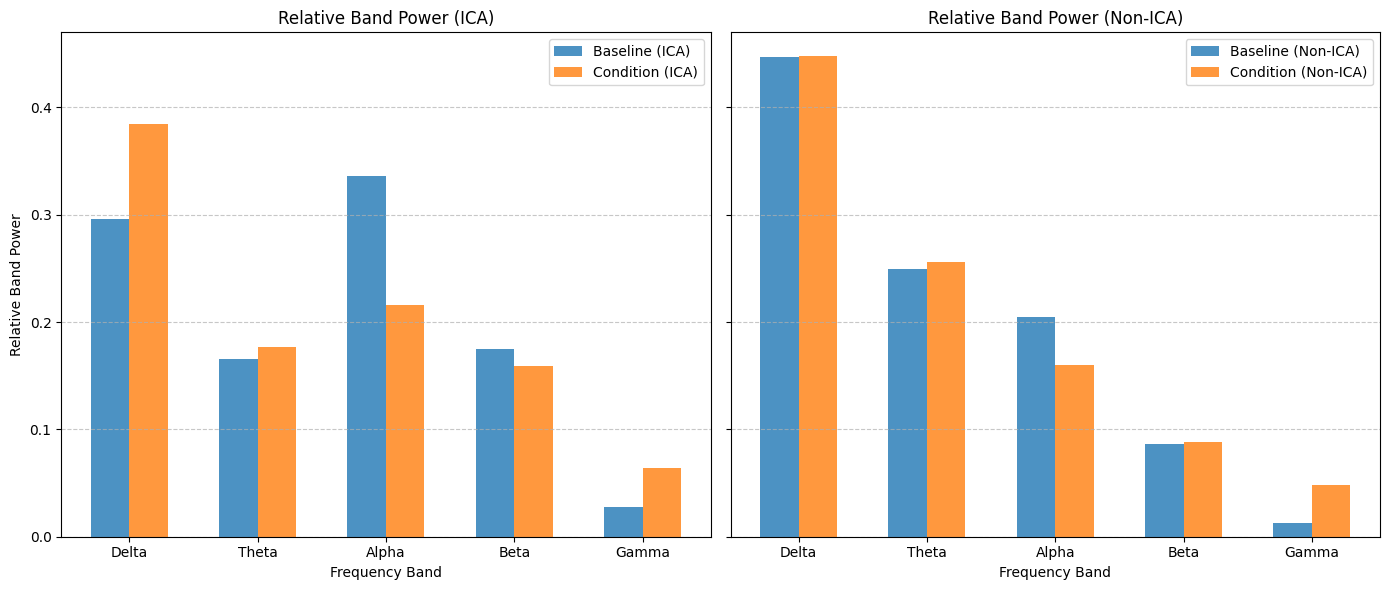


==== Relative Band Power (ICA Corrected) ====
Delta: Baseline = 0.296, Condition = 0.385
Theta: Baseline = 0.165, Condition = 0.176
Alpha: Baseline = 0.336, Condition = 0.216
Beta: Baseline = 0.175, Condition = 0.159
Gamma: Baseline = 0.028, Condition = 0.064

==== Relative Band Power (Non-ICA Corrected) ====
Delta: Baseline = 0.447, Condition = 0.448
Theta: Baseline = 0.249, Condition = 0.256
Alpha: Baseline = 0.205, Condition = 0.160
Beta: Baseline = 0.086, Condition = 0.088
Gamma: Baseline = 0.013, Condition = 0.048


In [198]:
# Define frequency bands
bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 50)
}

# Function to compute absolute and relative band power
def compute_relative_band_power(psd, freqs):
    absolute_power = {}
    
    for band, (fmin, fmax) in bands.items():
        band_mask = (freqs >= fmin) & (freqs <= fmax)  # Select frequencies within the band
        absolute_power[band] = np.mean(psd[:, band_mask], axis=1)  # Mean across selected freqs
    

    # Compute total power across all bands
    total_power = sum(absolute_power.values())

    
    # Compute relative power
    relative_power = {}

    # Compute relative power for each band
    for band, power in absolute_power.items():
        relative_power[band] = power / total_power
    
    return absolute_power, relative_power

# Compute relative power for ICA-corrected data
freqs_baseline = baseline_spectrum.freqs
freqs_condition = condition_spectrum.freqs
abs_power_baseline, rel_power_baseline = compute_relative_band_power(baseline_spectrum.get_data(), freqs_baseline)
abs_power_condition, rel_power_condition = compute_relative_band_power(condition_spectrum.get_data(), freqs_condition)

# Compute relative power for non-ICA corrected data
freqs_baseline_noICA = baseline_spectrum_noICA.freqs
freqs_condition_noICA = condition_spectrum_noICA.freqs
abs_power_baseline_noICA, rel_power_baseline_noICA = compute_relative_band_power(baseline_spectrum_noICA.get_data(), freqs_baseline_noICA)
abs_power_condition_noICA, rel_power_condition_noICA = compute_relative_band_power(condition_spectrum_noICA.get_data(), freqs_condition_noICA)

# Band labels
bands_list = list(bands.keys())

# Extract relative power values for ICA-corrected and non-ICA corrected data
baseline_ica = [rel_power_baseline[band].mean() for band in bands_list]
condition_ica = [rel_power_condition[band].mean() for band in bands_list]
baseline_noica = [rel_power_baseline_noICA[band].mean() for band in bands_list]
condition_noica = [rel_power_condition_noICA[band].mean() for band in bands_list]

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Bar width and positions
x = np.arange(len(bands_list))  # Band positions
width = 0.3  # Width of each bar

# Plot for ICA-corrected data
axes[0].bar(x - width/2, baseline_ica, width, label='Baseline (ICA)', alpha=0.8)
axes[0].bar(x + width/2, condition_ica, width, label='Condition (ICA)', alpha=0.8)
axes[0].set_xlabel("Frequency Band")
axes[0].set_ylabel("Relative Band Power")
axes[0].set_title("Relative Band Power (ICA)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(bands_list)
axes[0].legend()
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Plot for Non-ICA data
axes[1].bar(x - width/2, baseline_noica, width, label='Baseline (Non-ICA)', alpha=0.8)
axes[1].bar(x + width/2, condition_noica, width, label='Condition (Non-ICA)', alpha=0.8)
axes[1].set_xlabel("Frequency Band")
axes[1].set_title("Relative Band Power (Non-ICA)")
axes[1].set_xticks(x)
axes[1].set_xticklabels(bands_list)
axes[1].legend()
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Print results
print("\n==== Relative Band Power (ICA Corrected) ====")
for band in bands.keys():
    print(f"{band}: Baseline = {rel_power_baseline[band].mean():.3f}, Condition = {rel_power_condition[band].mean():.3f}")

print("\n==== Relative Band Power (Non-ICA Corrected) ====")
for band in bands.keys():
    print(f"{band}: Baseline = {rel_power_baseline_noICA[band].mean():.3f}, Condition = {rel_power_condition_noICA[band].mean():.3f}")

# Compute Euclidean Distance Between Conditions
- Calculate Euclidean distance between baseline and condition power spectra.
- Compare ICA and static channel selection approaches.


In [199]:
from scipy.spatial import distance

# Euclidean distance for ICA
euclidean_distance_ica = distance.euclidean(baseline_ica, condition_ica)
print("Euclidean Distance (ICA):", euclidean_distance_ica)

# Euclidean distance for Non-ICA
euclidean_distance_noica = distance.euclidean(baseline_noica, condition_noica)
print("Euclidean Distance (Non-ICA):", euclidean_distance_noica)

# Compute the difference
differential = euclidean_distance_ica - euclidean_distance_noica
print("Differential:", differential)

# Compute the percent difference
percent_increase = (differential / abs(euclidean_distance_noica)) * 100
print("Percent Increase:", percent_increase, "%")


Euclidean Distance (ICA): 0.15568046117905962
Euclidean Distance (Non-ICA): 0.057737932338545024
Differential: 0.0979425288405146
Percent Increase: 169.6328996788989 %
